# **Análise das avaliações em geral**

Uma análise detalhada em cima das avaliações dos clientes pode trazer diversos insights, como: principais pontos valorizados pelos clientes, problemas nos processos de vendas, palavras-chave de grupos de avaliações, entre outros.

**Observação: Optei por deixar apenas uma avaliação por pedido, pois há casos onde o id do pedido e da avaliação se repetem.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import metrics
from sklearn.cluster import KMeans
from wordcloud import WordCloud
# !pip install wordcloud

#### **Importação e análise**

In [2]:
produtos = pd.read_csv('../bases_de_dados/bases_trabalhadas/products_1.csv')
vendas = pd.read_csv('../bases_de_dados/bases_trabalhadas/orders_1_.csv', low_memory=False)
avaliacoes = pd.read_csv('../bases_de_dados/bases_trabalhadas/pedidos_e_avaliacoes.csv', low_memory=False)

In [3]:
vendas.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,dia_semana_compra
0,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,6916ca4502d6d3bfd39818759d55d536,1.0,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,-37.0,15,9,2016,12,Thursday
1,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaN,NaN,2016-10-24,49f695dffa457eaba90d388a5c37e942,1.0,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,NaN,22,10,2016,8,Saturday
2,e2144124f98f3bf46939bc5183104041,bd0342f59a3b8ddc416bd048b2b5d0fb,delivered,2016-10-06 20:06:26,2016-10-12 11:00:25,2016-10-15 11:00:25,2016-11-28,743d98b1a4782f0646898fc915ef002a,4.0,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,43.0,6,10,2016,20,Thursday


In [4]:
col_datas = ['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']
for i in col_datas:
    vendas[i] = pd.to_datetime(vendas[i], format='%Y-%m-%d %H:%M:%S')

In [5]:
vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        99441 non-null  object        
 1   customer_id                     99441 non-null  object        
 2   order_status                    99441 non-null  object        
 3   order_purchase_timestamp        99441 non-null  datetime64[ns]
 4   order_delivered_carrier_date    97658 non-null  object        
 5   order_delivered_customer_date   96476 non-null  datetime64[ns]
 6   order_estimated_delivery_date   99441 non-null  datetime64[ns]
 7   review_id                       98673 non-null  object        
 8   review_score                    98673 non-null  float64       
 9   review_comment_title            99441 non-null  object        
 10  review_comment_message          99441 non-null  object        
 11  re

In [6]:
avaliacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98095 entries, 0 to 98094
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   review_id                       98095 non-null  object 
 1   order_id                        98095 non-null  object 
 2   review_score                    98095 non-null  int64  
 3   review_comment_title            11509 non-null  object 
 4   review_comment_message          40554 non-null  object 
 5   review_creation_date            98095 non-null  object 
 6   review_answer_timestamp         98095 non-null  object 
 7   order_purchase_timestamp        98095 non-null  object 
 8   order_delivered_customer_date   95299 non-null  object 
 9   order_estimated_delivery_date   98095 non-null  object 
 10  diferenca_estimativa_e_entrega  95299 non-null  float64
 11  dia_compra                      98095 non-null  int64  
 12  mes_compra                      

In [7]:
avaliacoes.loc[avaliacoes.review_comment_title.isnull(), 'review_comment_title'] = 'sem_titulo'
avaliacoes.loc[avaliacoes.review_comment_message.isnull(), 'review_comment_message'] = 'sem_comentarios'

In [8]:
produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32951 non-null  object 
 3   product_description_lenght  32951 non-null  object 
 4   product_photos_qty          32951 non-null  object 
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.3+ MB


# **1. Avaliações**

In [9]:
avaliacoes.nunique()

review_id                         98095
order_id                          98095
review_score                          5
review_comment_title               4526
review_comment_message            36061
review_creation_date                756
review_answer_timestamp           97933
order_purchase_timestamp          97729
order_delivered_customer_date     94500
order_estimated_delivery_date       459
diferenca_estimativa_e_entrega      196
dia_compra                           31
mes_compra                           12
ano_compra                            3
hora_compra                          24
dtype: int64

#### **Criando bases separadamente**

In [10]:
nota1 = avaliacoes.loc[avaliacoes.review_score == 1]
nota2 = avaliacoes.loc[avaliacoes.review_score == 2]
nota3 = avaliacoes.loc[avaliacoes.review_score == 3]
nota4 = avaliacoes.loc[avaliacoes.review_score == 4]
nota5 = avaliacoes.loc[avaliacoes.review_score == 5]

In [11]:
# Quantidade de notas
avaliacoes.review_score.value_counts().sort_index()

1    11247
2     3103
3     8073
4    18951
5    56721
Name: review_score, dtype: int64

#### **Função para exibir as nuvens de palavras**

In [12]:
def exibir_nuvens(nota, wordcloud1, wordcloud2):
    fig, ax = plt.subplots(nrows=2, figsize=(9,8))
    ax[0].imshow(wordcloud1, interpolation = 'bilinear')
    ax[0].axis('off')

    ax[1].imshow(wordcloud2, interpolation = 'bilinear')
    ax[1].axis('off')

    ax[0].set_title('Palavras', fontweight='bold',fontsize=14)
    ax[1].set_title('Frases', fontweight='bold',fontsize=14)

    plt.suptitle(f'NUVEM DE PALAVRAS - {nota}', fontweight='bold', color='black', fontsize=18)
    plt.savefig(f"../imagens/{nota}_nuvens.png")
    plt.show()

In [13]:
palavras_nao_aparecer = ['a','e','que','de','o','em','para','meu','com','do','da','até','era','tarde','noite','dia','boatarde','bomdia','boanoite', 'Boatarde','Bomdia','Boanoite']

### **Nota 1:**

In [14]:
comentarios_nota1_palavras = ''
for i in nota1.loc[(nota1.order_id.notnull()) & (nota1.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota1_palavras += i
    comentarios_nota1_palavras += '  '
wordcloud_1_1 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota1_palavras)

comentarios_nota1_frases = ''
for i in nota1.loc[(nota1.order_id.notnull()) & (nota1.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota1_frases += i
    comentarios_nota1_frases += '  '
wordcloud_1_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota1_frases)

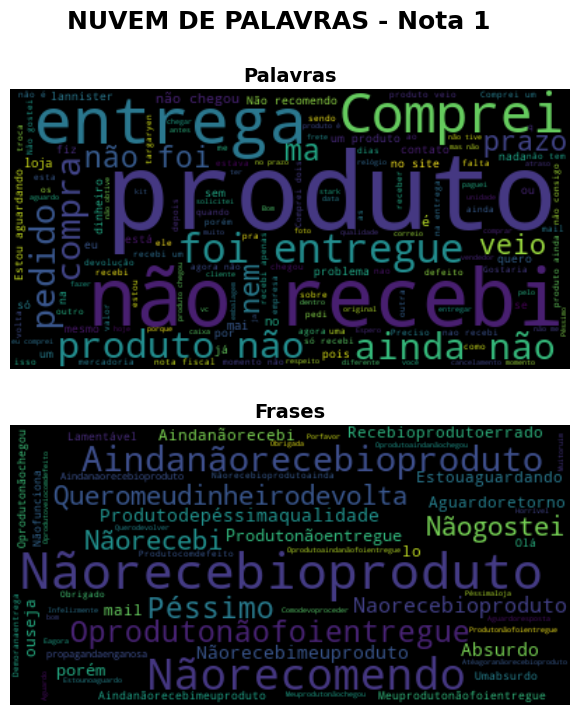

In [15]:
exibir_nuvens('Nota 1', wordcloud_1_1, wordcloud_1_2)

### **Nota 2:**

In [16]:
comentarios_nota2_palavras = ''
for i in nota2.loc[(nota2.order_id.notnull()) & (nota2.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota2_palavras += i
    comentarios_nota2_palavras += '  '
wordcloud_2_1 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota2_palavras)

comentarios_nota2_frases = ''
for i in nota2.loc[(nota2.order_id.notnull()) & (nota2.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota2_frases += i
    comentarios_nota2_frases += '  '
wordcloud_2_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota2_frases)

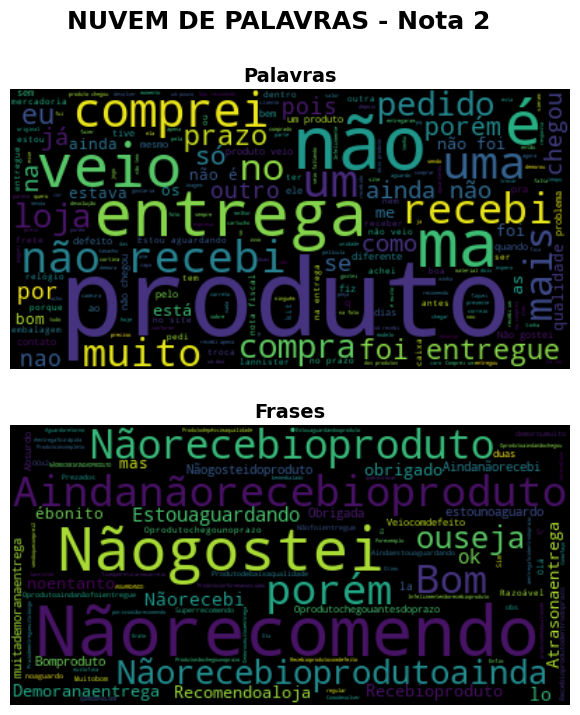

In [17]:
exibir_nuvens('Nota 2', wordcloud_2_1, wordcloud_2_2)

### **Nota 3:**

In [18]:
comentarios_nota3_palavras = ''
for i in nota3.loc[(nota3.order_id.notnull()) & (nota3.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota3_palavras += i
    comentarios_nota3_palavras += '  '
wordcloud_3_1 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota3_palavras)

comentarios_nota3_frases = ''
for i in nota3.loc[(nota3.order_id.notnull()) & (nota3.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota3_frases += i
    comentarios_nota3_frases += '  '
wordcloud_3_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota3_frases)

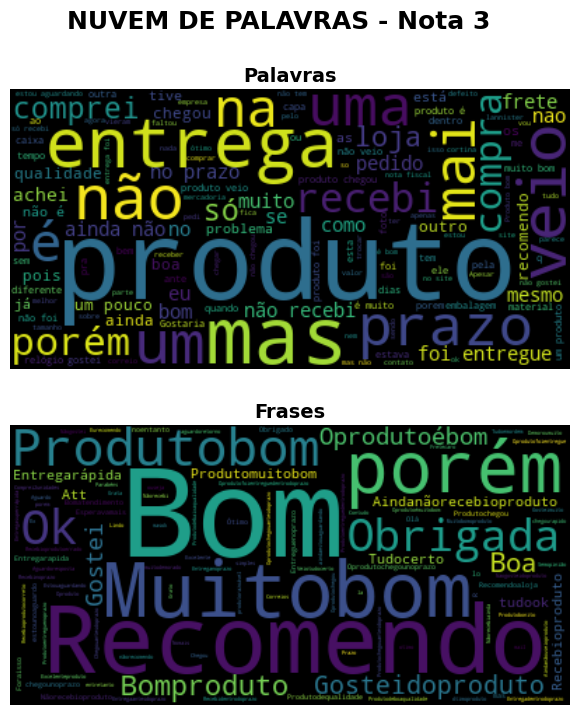

In [19]:
exibir_nuvens("Nota 3", wordcloud_3_1, wordcloud_3_2)

### **Nota 4:**

In [20]:
comentarios_nota4_palavras = ''
for i in nota4.loc[(nota4.order_id.notnull()) & (nota4.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota4_palavras += i
    comentarios_nota4_palavras += '  '
wordcloud_4_1 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota4_palavras)

comentarios_nota4_frases = ''
for i in nota4.loc[(nota4.order_id.notnull()) & (nota4.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota4_frases += i
    comentarios_nota4_frases += '  '
wordcloud_4_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota4_frases)

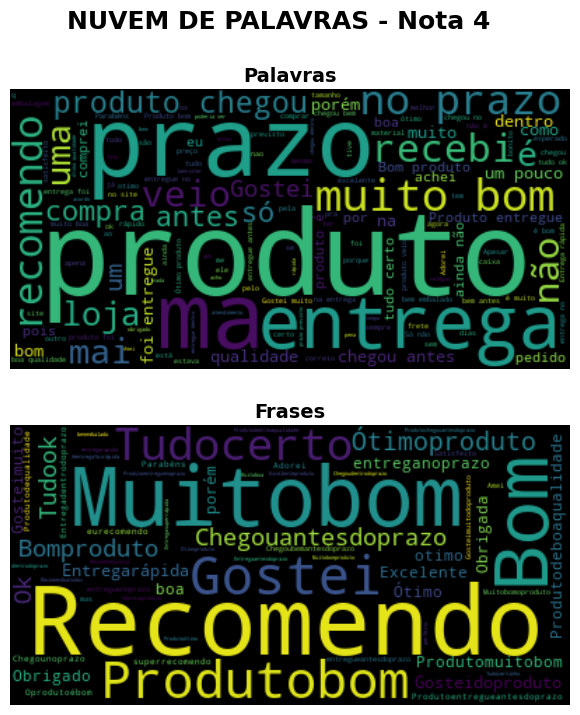

In [21]:
exibir_nuvens("Nota 4", wordcloud_4_1, wordcloud_4_2)

### **Nota 5:**

In [22]:
comentarios_nota5_palavras = ''
for i in nota5.loc[(nota5.order_id.notnull()) & (nota5.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    comentarios_nota5_palavras += i
    comentarios_nota5_palavras += '  '
wordcloud_5_1 = WordCloud(stopwords=['a','e','que','de','o']).generate(comentarios_nota5_palavras)

comentarios_nota5_frases = ''
for i in nota5.loc[(nota5.order_id.notnull()) & (nota5.review_comment_message != 'sem_comentarios'),'review_comment_message']:
    if i:
        i = i.replace(' ', '')
    comentarios_nota5_frases += i
    comentarios_nota5_frases += '  '
wordcloud_5_2 = WordCloud(stopwords=palavras_nao_aparecer).generate(comentarios_nota5_frases)

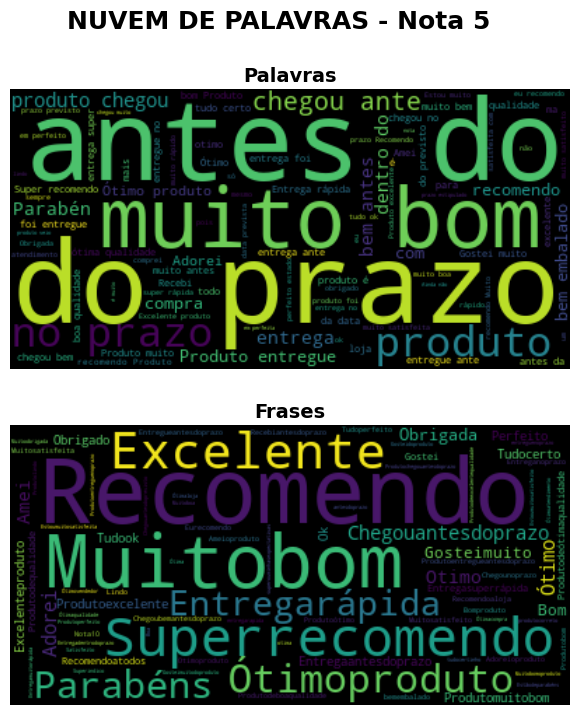

In [23]:
exibir_nuvens("Nota 5", wordcloud_5_1, wordcloud_5_2)

#### **Analisando as nuvens de palavras das notas:**

- Notamos que grande parte das avaliações de nota 1 são devido a atrasos nos pedidos, nas notas 2 muitos não gostaram, mas também há vários relatos de produtos não entregues.

#### **Concluindo:**
- As ocorrências de avaliações baixas possuem diversos motivos, como: atraso na entrega, produto de má qualidade, problemas com o funcionamento do produto, mal atendimento, entre outros. Portanto, apesar do atraso ser bem frequente nas avaliações de nota 1, é importante não generalizarmos, pois possuem outras causas.

# **2. Atraso**

In [24]:
vendas.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,dia_semana_compra
0,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,6916ca4502d6d3bfd39818759d55d536,1.0,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,-37.0,15,9,2016,12,Thursday
1,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaN,NaT,2016-10-24,49f695dffa457eaba90d388a5c37e942,1.0,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,NaN,22,10,2016,8,Saturday
2,e2144124f98f3bf46939bc5183104041,bd0342f59a3b8ddc416bd048b2b5d0fb,delivered,2016-10-06 20:06:26,2016-10-12 11:00:25,2016-10-15 11:00:25,2016-11-28,743d98b1a4782f0646898fc915ef002a,4.0,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,43.0,6,10,2016,20,Thursday
3,b8b9d7046c083150cb5360b83a8ebb51,ec271753df25bad1135a375ed6d7f113,delivered,2016-10-06 12:51:54,2016-10-15 12:24:17,2016-10-18 13:24:17,2016-11-28,53752edb26544dd41c1209f582c9c589,5.0,sem_titulo,O pedido foi entregue antes do prazo pr0metido,2016-10-16 01:00:00,2016-10-16 15:45:11,40.0,6,10,2016,12,Thursday
4,9aa3197e4887919fde0307fc23601d7a,31a4ecf0bd3ea9436b7132bac1a1bdb3,delivered,2016-10-06 13:16:56,2016-10-14 18:08:17,2016-10-17 19:08:17,2016-11-28,b2d5d8db2a841d27a72e4c06c6212368,4.0,sem_titulo,Só chegou uma parte do pedido ate agora..,2016-10-15 00:00:00,2016-10-17 21:02:49,41.0,6,10,2016,13,Thursday


In [25]:
vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        99441 non-null  object        
 1   customer_id                     99441 non-null  object        
 2   order_status                    99441 non-null  object        
 3   order_purchase_timestamp        99441 non-null  datetime64[ns]
 4   order_delivered_carrier_date    97658 non-null  object        
 5   order_delivered_customer_date   96476 non-null  datetime64[ns]
 6   order_estimated_delivery_date   99441 non-null  datetime64[ns]
 7   review_id                       98673 non-null  object        
 8   review_score                    98673 non-null  float64       
 9   review_comment_title            99441 non-null  object        
 10  review_comment_message          99441 non-null  object        
 11  re

In [26]:
vendas.diferenca_estimativa_e_entrega.isnull().sum()

2965

**Obs: Esses 2965 valores foram de produtos ainda não entregues, como vimos no notebook "01 - Primeiras limpezas e insights"**

In [27]:
vendas['atraso'] = vendas.diferenca_estimativa_e_entrega.apply(lambda x:1 if x < 0 else 0)
vendas

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,dia_semana_compra,atraso
0,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,6916ca4502d6d3bfd39818759d55d536,1.0,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,-37.0,15,9,2016,12,Thursday,1
1,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaN,NaT,2016-10-24,49f695dffa457eaba90d388a5c37e942,1.0,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,NaN,22,10,2016,8,Saturday,0
2,e2144124f98f3bf46939bc5183104041,bd0342f59a3b8ddc416bd048b2b5d0fb,delivered,2016-10-06 20:06:26,2016-10-12 11:00:25,2016-10-15 11:00:25,2016-11-28,743d98b1a4782f0646898fc915ef002a,4.0,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,43.0,6,10,2016,20,Thursday,0
3,b8b9d7046c083150cb5360b83a8ebb51,ec271753df25bad1135a375ed6d7f113,delivered,2016-10-06 12:51:54,2016-10-15 12:24:17,2016-10-18 13:24:17,2016-11-28,53752edb26544dd41c1209f582c9c589,5.0,sem_titulo,O pedido foi entregue antes do prazo pr0metido,2016-10-16 01:00:00,2016-10-16 15:45:11,40.0,6,10,2016,12,Thursday,0
4,9aa3197e4887919fde0307fc23601d7a,31a4ecf0bd3ea9436b7132bac1a1bdb3,delivered,2016-10-06 13:16:56,2016-10-14 18:08:17,2016-10-17 19:08:17,2016-11-28,b2d5d8db2a841d27a72e4c06c6212368,4.0,sem_titulo,Só chegou uma parte do pedido ate agora..,2016-10-15 00:00:00,2016-10-17 21:02:49,41.0,6,10,2016,13,Thursday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,0c384d67524b5b92aa2fa6c8baa9a983,53421895d40d7df28d68c22ffa043355,delivered,2017-06-05 19:20:11,2017-06-07 11:23:06,2017-06-13 14:09:21,2017-06-27,NaN,NaN,sem_titulo,sem_comentarios,NaN,NaN,13.0,5,6,2017,19,Monday,0
99437,906a6b0a96d89ee226e4977e99b80b9e,274a720e69d300bc7696c8570f8978fe,delivered,2017-08-28 15:14:21,2017-08-31 15:25:01,2017-09-05 19:47:44,2017-09-18,NaN,NaN,sem_titulo,sem_comentarios,NaN,NaN,12.0,28,8,2017,15,Monday,0
99438,5333db16fe357175d39c82840dd3269d,7e008e5ec21e044fe30c34ec4e9d0747,delivered,2018-03-10 18:18:20,2018-03-13 17:58:52,2018-04-03 15:32:52,2018-03-29,NaN,NaN,sem_titulo,sem_comentarios,NaN,NaN,-6.0,10,3,2018,18,Saturday,1
99439,2f2df159f26ddb73d55ee72372200d3e,86a7245fffe6a418ca1658a13ecc4531,delivered,2017-07-17 01:19:50,2017-07-17 22:14:50,2017-07-26 09:44:00,2017-08-09,NaN,NaN,sem_titulo,sem_comentarios,NaN,NaN,13.0,17,7,2017,1,Monday,0


In [28]:
vendas['atraso'].value_counts()

0    91614
1     7827
Name: atraso, dtype: int64

In [29]:
avaliacoes = pd.merge(avaliacoes, vendas[['order_id','atraso']], on='order_id',how='inner')

In [30]:
avaliacoes.isnull().sum()

review_id                            0
order_id                             0
review_score                         0
review_comment_title                 0
review_comment_message               0
review_creation_date                 0
review_answer_timestamp              0
order_purchase_timestamp             0
order_delivered_customer_date     2796
order_estimated_delivery_date        0
diferenca_estimativa_e_entrega    2796
dia_compra                           0
mes_compra                           0
ano_compra                           0
hora_compra                          0
atraso                               0
dtype: int64

In [31]:
avaliacoes.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,atraso
0,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,-37.0,15,9,2016,12,1
1,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,2016-10-22 08:25:27,NaN,2016-10-24,NaN,22,10,2016,8,0
2,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,2016-10-06 20:06:26,2016-10-15 11:00:25,2016-11-28,43.0,6,10,2016,20,0


In [32]:
avaliacoes.groupby('atraso')['review_score'].mean()

atraso
0    4.216918
1    2.566968
Name: review_score, dtype: float64

**Operação inversa**

In [33]:
avaliacoes.groupby('review_score')['atraso'].value_counts()

review_score  atraso
1             0          7729
              1          3518
2             0          2504
              1           599
3             0          7205
              1           868
4             0         18009
              1           942
5             0         55025
              1          1696
Name: atraso, dtype: int64

In [34]:
nota1 = avaliacoes.loc[avaliacoes.review_score == 1]
nota2 = avaliacoes.loc[avaliacoes.review_score == 2]
nota3 = avaliacoes.loc[avaliacoes.review_score == 3]
nota4 = avaliacoes.loc[avaliacoes.review_score == 4]
nota5 = avaliacoes.loc[avaliacoes.review_score == 5]

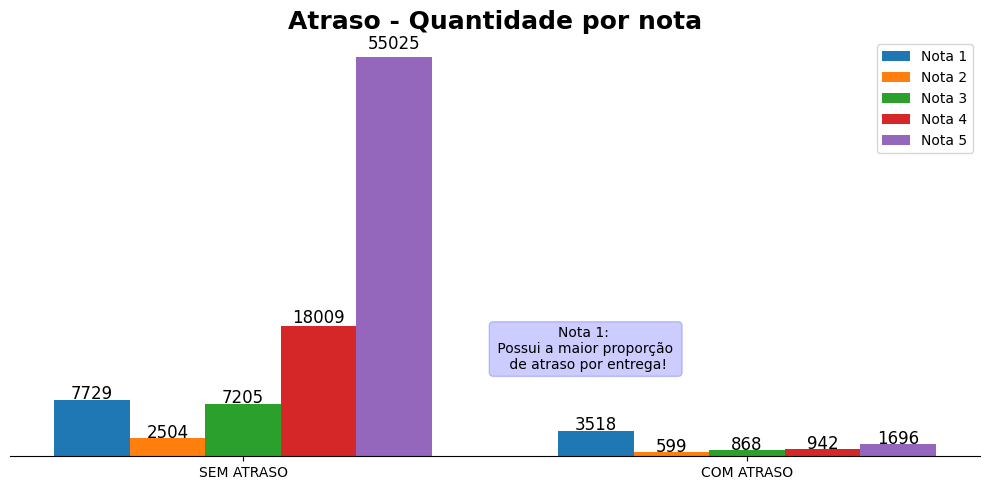

In [35]:
a = nota1.atraso.value_counts()
b = nota2.atraso.value_counts()
c = nota3.atraso.value_counts()
d = nota4.atraso.value_counts()
e = nota5.atraso.value_counts()

w=0.15
fig, ax = plt.subplots(figsize=(10,5), tight_layout=True)
ax.bar(a.index-w*2, a.values, width=w, label='Nota 1')
ax.bar(b.index-w, b.values, width=w, label='Nota 2')
ax.bar(c.index, c.values, width=w, label='Nota 3')
ax.bar(d.index+w, d.values, width=w, label='Nota 4')
ax.bar(e.index+w*2, e.values, width=w, label='Nota 5')
ax.legend()
ax.set_xticks([0,1])
ax.set_xticklabels(['SEM ATRASO', 'COM ATRASO'])
ax.spines[['top','left','right']].set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Atraso - Quantidade por nota', fontweight='bold', fontsize=18)

for i in range(2):
    ax.annotate(a.values[i], (a.index[i]-w*2, a.values[i]+a.values[i]*0.02), ha='center', fontsize=12)
    ax.annotate(b.values[i], (b.index[i]-w, b.values[i]+b.values[i]*0.02), ha='center', fontsize=12)
    ax.annotate(c.values[i], (c.index[i], c.values[i]+c.values[i]*0.02), ha='center', fontsize=12)
    ax.annotate(d.values[i], (d.index[i]+w, d.values[i]+d.values[i]*0.02), ha='center', fontsize=12)
    ax.annotate(e.values[i], (e.index[i]+w*2, e.values[i]+e.values[i]*0.02), ha='center', fontsize=12)
    
ax.text(0.68, 12000, 'Nota 1: \n Possui a maior proporção \n de atraso por entrega!', ha='center', bbox=dict(facecolor='blue', edgecolor='blue', boxstyle='round,pad=0.3', alpha=0.2))
    
# plt.savefig('../imagens/atraso_qtd_nota.png', transparent=True)
plt.show()

Como podemos ver acima, grande porcentagem das avaliações nota 1 houveram atraso. Quando comparamos percentualmente as proporções com as outras notas, vemos uma alta correlação entre a nota 1 e a classe de atraso.

In [36]:
avaliacoes.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,diferenca_estimativa_e_entrega,dia_compra,mes_compra,ano_compra,hora_compra,atraso
0,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,sem_titulo,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,-37.0,15,9,2016,12,1
1,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,sem_titulo,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29,2016-10-22 08:25:27,NaN,2016-10-24,NaN,22,10,2016,8,0
2,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,sem_titulo,sem_comentarios,2016-10-15 00:00:00,2016-10-16 03:20:17,2016-10-06 20:06:26,2016-10-15 11:00:25,2016-11-28,43.0,6,10,2016,20,0


### **Analisando a correlação entre a nota e o atraso**

In [37]:
correlacoes = avaliacoes[['review_score','atraso']].copy()
correlacoes.head(3)

,review_score,atraso
0,1,1
1,1,0
2,4,0


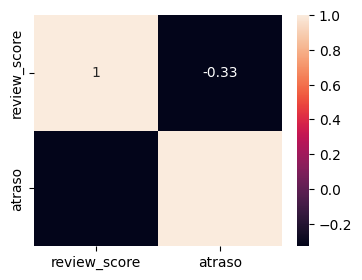

In [38]:
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(correlacoes.corr(), annot=True, ax=ax)
plt.show()

#### **Através da coluna produtos, podemos analisar outras correlações relacionadas ao produto com a target "atraso"**

In [42]:
itens_pedidos = pd.read_csv('../bases_de_dados/bases_trabalhadas/order_items_1.csv')
itens_pedidos.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff


In [43]:
itens_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98666 entries, 0 to 98665
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               98666 non-null  object 
 1   order_item_id          98666 non-null  int64  
 2   product_id             98666 non-null  object 
 3   seller_id              98666 non-null  object 
 4   shipping_limit_date    98666 non-null  object 
 5   price                  98666 non-null  float64
 6   freight_value          98666 non-null  float64
 7   product_category_name  97248 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 6.0+ MB


In [44]:
analise_produtos = pd.merge(avaliacoes[['order_id','review_score','diferenca_estimativa_e_entrega','atraso']],
                            itens_pedidos[['order_id','order_item_id','product_id','seller_id','product_category_name']],
                            on='order_id', how='left')

In [46]:
analise_produtos.nunique()

order_id                          98095
review_score                          5
diferenca_estimativa_e_entrega      196
atraso                                2
order_item_id                        17
product_id                        31599
seller_id                          3074
product_category_name                73
dtype: int64

In [47]:
analise_produtos.head(1)

,order_id,review_score,diferenca_estimativa_e_entrega,atraso,order_item_id,product_id,seller_id,product_category_name
0,bfbd0f9bdef84302105ad712db648a6c,1,-37.0,1,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,beleza_saude


In [48]:
analise_produtos.drop(['order_id','product_id', 'seller_id', 'product_category_name'], axis=1).corr()

,review_score,diferenca_estimativa_e_entrega,atraso,order_item_id
review_score,1.000000,0.267704,-0.328228,-0.115238
diferenca_estimativa_e_entrega,0.267704,1.000000,-0.602586,0.031537
atraso,-0.328228,-0.602586,1.000000,-0.015668
order_item_id,-0.115238,0.031537,-0.015668,1.000000
